In [1]:
import pandas as pd
import sys  
sys.path.insert(0, '../scripts')
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
import clean_data
import loading_data
import utilities
from sklearn.neighbors import LocalOutlierFactor
import visualize
import datetime
from datetime import timedelta  


In [2]:
# load data
df_store = loading_data.load_csv('../data/store.csv')
df_train = loading_data.load_csv('../data/train.csv')
df_test = loading_data.load_csv('../data/test.csv')
df_submission = loading_data.load_csv('../data/sample_submission.csv')

/home/dibora/Pharmaceutical-Sales-prediction-across-multiple-stores/pharmaceutical/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  
/home/dibora/Pharmaceutical-Sales-prediction-across-multiple-stores/pharmaceutical/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  This is separate from the ipykernel package so we can avoid doing imports until
/home/dibora/Pharmaceutical-Sales-prediction-across-multiple-stores/pharmaceutical/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  after removing the cwd from sys.path.
/home/dibora/Pharmaceutical-Sales-prediction-across-multiple-stores/pharmaceutical/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarn

In [3]:
df_store.head(5),df_store.nunique()


(   Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
 0      1         c          a             1,270.00                       9.00   
 1      2         a          a               570.00                      11.00   
 2      3         a          a            14,130.00                      12.00   
 3      4         c          c               620.00                       9.00   
 4      5         a          a            29,910.00                       4.00   
 
    CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
 0                  2,008.00       0              NaN              NaN   
 1                  2,007.00       1            13.00         2,010.00   
 2                  2,006.00       1            14.00         2,011.00   
 3                  2,009.00       0              NaN              NaN   
 4                  2,015.00       0              NaN              NaN   
 
      PromoInterval  
 0              NaN  
 1  Jan,Apr,Jul,

In [4]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


### Store data
The store data gives us additional information about the stores, we can see from the data that we have 1115 stores which are of 4 types, and we also include columns with additional information for each stores, like Store type,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2SinceWeek ,Promo2SinceYear,PromoInterval

In [5]:
df_train.head(), df_train.nunique()

(   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
 0      1          5  2015-07-31   5263        555     1      1            0   
 1      2          5  2015-07-31   6064        625     1      1            0   
 2      3          5  2015-07-31   8314        821     1      1            0   
 3      4          5  2015-07-31  13995       1498     1      1            0   
 4      5          5  2015-07-31   4822        559     1      1            0   
 
    SchoolHoliday  
 0              1  
 1              1  
 2              1  
 3              1  
 4              1  ,
 Store             1115
 DayOfWeek            7
 Date               942
 Sales            21734
 Customers         4086
 Open                 2
 Promo                2
 StateHoliday         4
 SchoolHoliday        2
 dtype: int64)

Store data contains 1115 rows by 10 columns, we can see there are missing values from the data. 

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [8]:
# questions you have to ask what store data is and what it represents
# how to choose the best methods for cleaning missing data and outliers


## clean Data

In [9]:
# convert date columns to datetime format
df_train = utilities.format_datetime(df_train,"Date")
# df_store["CompetitionOpenSinceMonth"] = df_store["CompetitionOpenSinceMonth"].to_string()
# df_store["CompetitionOpenSinceYear"] = df_store["CompetitionOpenSinceYear"].to_string()
df_store.head(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,"1,270.00",9.00,"2,008.00",0,NaN,NaN,NaN
1,2,a,a,570.00,11.00,"2,007.00",1,13.00,"2,010.00","Jan,Apr,Jul,Oct"
2,3,a,a,"14,130.00",12.00,"2,006.00",1,14.00,"2,011.00","Jan,Apr,Jul,Oct"
3,4,c,c,620.00,9.00,"2,009.00",0,NaN,NaN,NaN
4,5,a,a,"29,910.00",4.00,"2,015.00",0,NaN,NaN,NaN
5,6,a,a,310.00,12.00,"2,013.00",0,NaN,NaN,NaN
6,7,a,c,"24,000.00",4.00,"2,013.00",0,NaN,NaN,NaN
7,8,a,a,"7,520.00",10.00,"2,014.00",0,NaN,NaN,NaN
8,9,a,c,"2,030.00",8.00,"2,000.00",0,NaN,NaN,NaN
9,10,a,a,"3,160.00",9.00,"2,009.00",0,NaN,NaN,NaN


In [10]:
# cleaning missing values by just dropping them, do more analysis later
# our train data doesn't have any missing values
cleaned_store = clean_data.Handle_missing_values(df_store,drop_cols=False,drop_rows=False)
cleaned_test = clean_data.Handle_missing_values(df_test,drop_cols=False,drop_rows=False)
cleaned_store.info(), cleaned_test.info()

['StoreType', 'Assortment', 'PromoInterval']
['Date', 'StateHoliday']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  1115 non-null   float64
 5   CompetitionOpenSinceYear   1115 non-null   float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            1115 non-null   float64
 8   Promo2SinceYear            1115 non-null   float64
 9   PromoInterval              1115 non-null   object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns

(None, None)

In [11]:
# To remove outliers we can use statistical methods like removing values that lie 
# outside our 2,3 or 4 sigma depending on the size of our data
# We can also use ml sklearn localoutlierfactor library to calculate the distance
# between data points to determine the one with the largest distance 

# lof = LocalOutlierFactor()
# df_train = lof.fit_predict(df_train)

# Exploring customer behaviour
## Check for distribution in both training and test sets - Are the promotions distributed similarly between these two groups?
### We will plot the number of stores that do promotions in both the training and testing data to study the difference


In [14]:

# df_train["Promo"].head(3),df_train["Promo"].head(3)
df_train_stores = df_train.groupby("Store")
df_test_stores = df_test.groupby("Store")
# visualize.displot(df_train,x="Promo",title = "Promo distribution over Training set ")
# visualize.displot(df_test,x="Promo",title = "Promo distribution over Test set ")
# sn.displot(data=df_train,x="Promo")
# sn.displot(data=df_test,x="Promo")
# df_train_stores.head()


## Check & compare sales behavior before, during and after holidays
### We will plot the Sales during the holiday season to see if there is a different purchasing behavior than the casual days. 

#### study which dates are holidays

In [22]:

df_holidays = df_train.query('StateHoliday != "0"')
# getting the dates for the holidays in the above dataframe
df_holidays_dates = df_holidays.drop_duplicates('Date')

df_holidays_dates


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
63555,1,4,2015-06-04,0,0,0,1,a,0
74705,1,1,2015-05-25,0,0,0,0,a,0
86970,1,4,2015-05-14,0,0,0,0,a,0
101465,1,5,2015-05-01,0,0,0,1,a,0
129340,1,1,2015-04-06,0,0,0,0,b,1
132685,1,5,2015-04-03,0,0,0,1,b,1
229702,13,2,2015-01-06,0,0,0,1,a,0
235265,1,4,2015-01-01,0,0,0,0,a,1
241055,1,5,2014-12-26,0,0,0,0,c,1
241990,1,4,2014-12-25,0,0,0,0,c,1


#### As we can see from our data Public Holidays don't usually stay for very long so we will analyze purchasing behaviours during,after and before chrismas and Easter. We will consider chrismas as December 26 and 25, we will analyze 5 days before Dec 25 and 5 days after Dec 26. Easter varies but stays 3 days so we will get the days for each year and analyze 5 days before and 5 days after those days for year in range(2013,2016).



In [48]:
# get the begining date of easter for each year
easter_beginings = df_holidays_dates.query("StateHoliday == 'b' & DayOfWeek == 5")['Date'].dt.date.tolist()

# Add a column that states if a date is during, after or during a chrismas or easter holiday
df_train_copy = df_train.copy()
df_train_copy.loc[:,"Holiday_season"] = "not_around_holiday" 

for year in range(2013,2016):
    chrismas_before_mask = (df_train_copy['Date'] > datetime.datetime(year,12,20)) & (df_train_copy['Date'] < datetime.datetime(year,12,25))
    chrismas_after_mask = (df_train_copy['Date'] > datetime.datetime(year,12,26)) & (df_train_copy['Date'] < datetime.datetime(year,12,31))
    chrismas_mask = (df_train_copy['Date'] == datetime.datetime(year,12,25)) | (df_train_copy['Date'] == datetime.datetime(year,12,26))
    # for each year get 5 days before and after easter
    for easter_date in easter_beginings:
        easter_before_mask = (df_train_copy['Date'].dt.date > (easter_date -timedelta(days=5))) & (df_train_copy['Date'].dt.date < easter_date)
        easter_after_mask = (df_train_copy['Date'].dt.date > easter_date+ timedelta(days=3)) & (df_train_copy['Date'].dt.date < easter_date+ timedelta(days=8))
        easter_mask = (df_train_copy['Date'].dt.date >= easter_date) & (df_train_copy['Date'].dt.date <= easter_date+timedelta(days=3))
        # add to the Holiday season col, the days around easter
        df_train_copy.loc[easter_before_mask,"Holiday_season"] = "before_easter" 
        df_train_copy.loc[easter_after_mask,"Holiday_season"] = "after_easter" 
        df_train_copy.loc[easter_mask,"Holiday_season"] = "during_easter"
    # add to the Holiday season col, the days around chrismas
    df_train_copy.loc[chrismas_before_mask,"Holiday_season"] = "before_chrismas" 
    df_train_copy.loc[chrismas_after_mask,"Holiday_season"] = "after_chrismas" 
    df_train_copy.loc[chrismas_mask,"Holiday_season"] = "during_chrismas" 

df_train_copy.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Holiday_season
0,1,5,2015-07-31,5263,555,1,1,0,1,not_around_holiday
1,2,5,2015-07-31,6064,625,1,1,0,1,not_around_holiday
2,3,5,2015-07-31,8314,821,1,1,0,1,not_around_holiday
3,4,5,2015-07-31,13995,1498,1,1,0,1,not_around_holiday
4,5,5,2015-07-31,4822,559,1,1,0,1,not_around_holiday


/home/dibora/Pharmaceutical-Sales-prediction-across-multiple-stores/pharmaceutical/lib/python3.7/site-packages/seaborn/categorical.py:3747: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x504 with 0 Axes>

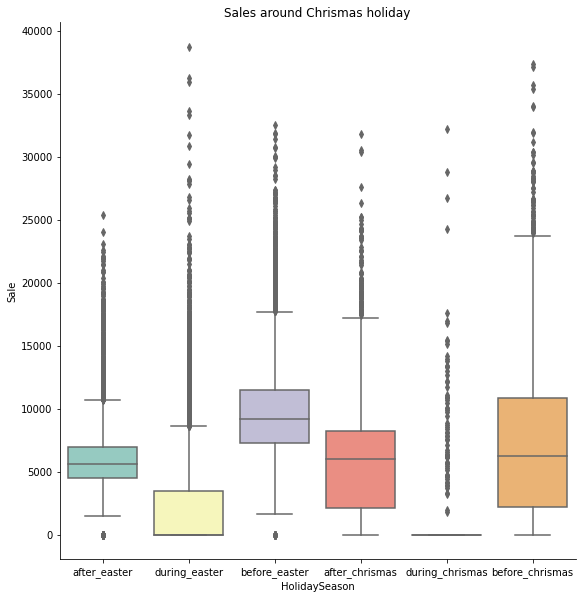

In [33]:
# visualizing sales around Holiday Season
visualize.catplot(df_train_copy,y="Sales",x="Holiday_season",kind="box",title="Sales around Chrismas holiday",palette='Set3',xlabel="HolidaySeason",ylabel="Sale",size=8)

#### As we we are able to see from the plots, Purchasing behavior is the highest before chrismas than the other holiday season days, and the lowest during chrismas. If we can add and see how the holiday season affect sales compared to the non-holiday ones is great. We will plot the daily sales plot and mark days around the holiday to study how sales were affected. 

#### Daily Sales Distribution

<Figure size 864x504 with 0 Axes>

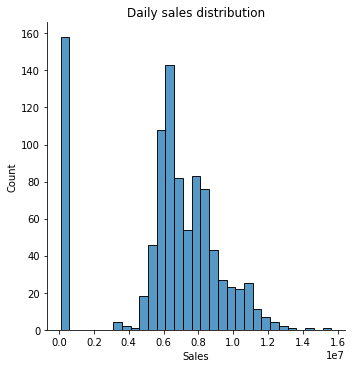

In [21]:
df_daily_sales = df_train.groupby(pd.Grouper(key='Date', axis=0,freq='D')).sum()
visualize.displot(df_daily_sales,x="Sales",title="Daily sales distribution")
# df_daily_sales.sort_values(by="Sales",ascending=False).reset_index().head(10)

#### We can see from the above plot that the daily sales are a normal distribution, although we can see some outlier points, which we can study further and how they are caused. By plotting daily sales of stores, We are trying to study the daily sales and changes we can notice during holidays.We will put markers on the peak values, to study them further.

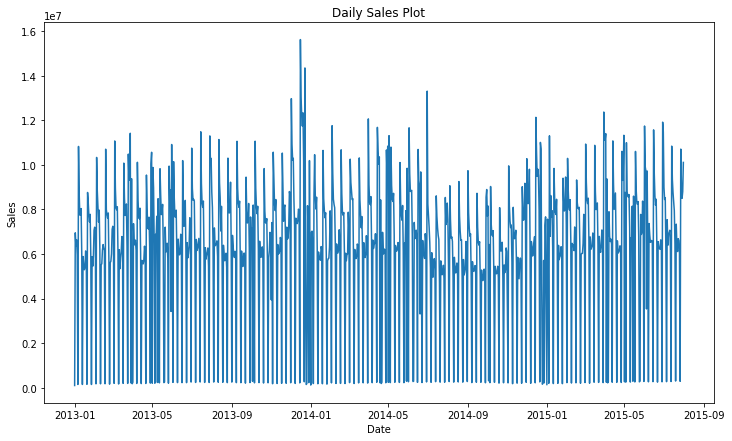

In [23]:
# Daily Sales Plot
visualize.lineplot(df_daily_sales,y="Sales",x="Date",title="Daily Sales Plot")

In [47]:
# Get Total monthly sales 
monthly_total_sales = df_train_copy.groupby(pd.Grouper(key='Date', axis=0,freq='M')).sum()
monthly_total_sales.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
Date,,,,,,,
2013-01-31,19286282,134913,180132207,20380423,28869,11150,5115
2013-02-28,17420760,124880,171534275,19244468,26683,11150,2676
2013-03-31,19287270,144950,201180369,21969462,27892,16725,5689
2013-04-30,18665100,128225,183431432,20882365,27880,13380,5319
2013-05-31,19287270,138260,185411063,20723886,26202,14495,3774


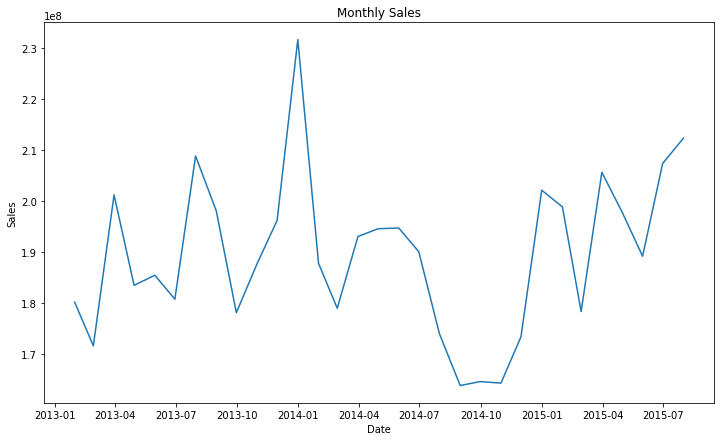

In [45]:
visualize.lineplot(monthly_total_sales,x="Date",y="Sales",title="Monthly Sales")

## Find out any seasonal (Christmas, Easter etc) purchase behaviours
### We can anlyze the sales during chrismas and Easter,which includes customers, the type of stores favored during the holidays and the sales.

In [50]:
# But for this we need to analyze additional store behavior, so lets join store df and train df
df_train_joined = df_train.merge(df_store, on='Store')
df_train_joined.head(5)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,"1,270.00",9.00,"2,008.00",0,22.00,"2,012.00","Jan,Apr,Jul,Oct"
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,"1,270.00",9.00,"2,008.00",0,22.00,"2,012.00","Jan,Apr,Jul,Oct"
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,"1,270.00",9.00,"2,008.00",0,22.00,"2,012.00","Jan,Apr,Jul,Oct"
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,"1,270.00",9.00,"2,008.00",0,22.00,"2,012.00","Jan,Apr,Jul,Oct"
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,"1,270.00",9.00,"2,008.00",0,22.00,"2,012.00","Jan,Apr,Jul,Oct"


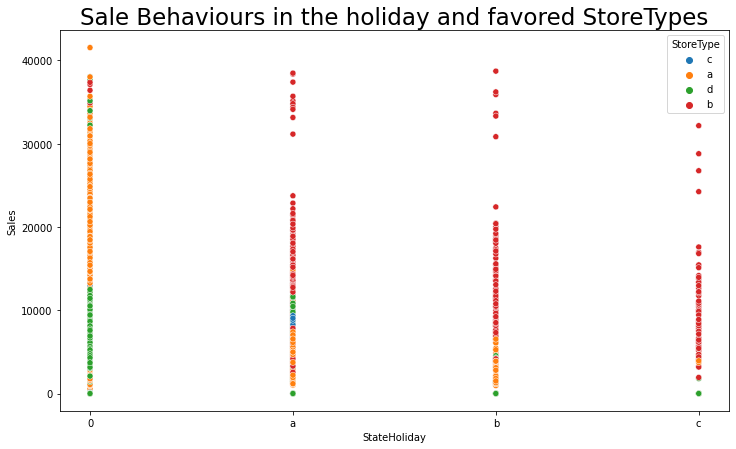

In [52]:
# A simple plot to show the store types favored during Holidays
visualize.scatterplot(df_train_joined,y="Sales",x="StateHoliday",hue="StoreType",title="Sale Behaviours in the holiday and favored StoreTypes")


<!-- a = public holiday, b = Easter holiday, c = Christmas, 0 = None -->
#### The plots show that during Easter holiday and christmas store type b and a are preferred, During public holiday mostly just type b stores are preferred and on non-holiday days store types a and d are preferred.


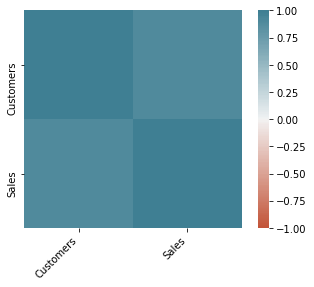

In [51]:
# What can you say about the correlation between sales and number of customers?
corr = df_train[['Customers','Sales']].corr()
visualize.correlation_heatmap(corr)

In [52]:
# or in other ways we can use the spearman correlation 
# If you are unsure of the distribution and possible relationships between two variables,
#  Spearman correlation coefficient is a good tool to use.
spearman_corr, _ = spearmanr(df_train['Customers'],df_train['Sales'])
print('Spearmans correlation: %.3f' % spearman_corr)

Spearmans correlation: 0.903


#### Which shows a high positive correlation between the two variables. Which means one increases the other increases aswell

<Figure size 864x504 with 0 Axes>

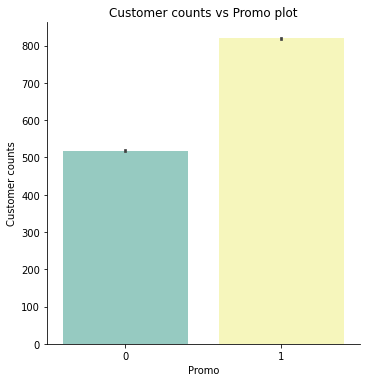

In [53]:
# How does promo affect sales? Are the promos attracting more customers? How does it affect already existing customers?
visualize.catplot(df_train_joined,y="Customers",x="Promo",kind="bar",title="Customer counts vs Promo plot",xlabel="Promo",ylabel="Customer counts")

In [54]:
# don't think it is enough, add more 

<Figure size 864x504 with 0 Axes>

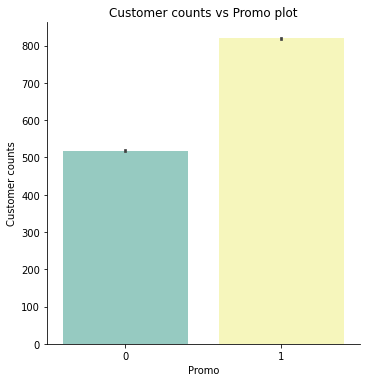

In [55]:
# Could the promos be deployed in more effective ways? Which stores should promos be deployed in?
# what do we need to consider to say it needs to be deployed effectively? There are no columns that talk about
# promo deployment
visualize.catplot(df_train_joined,y="Customers",x="Promo",kind="bar",title="Customer counts vs Promo plot",xlabel="Promo",ylabel="Customer counts")

In [56]:
# Trends of customer behavior during store open and closing times
# visualize.scatterplot(df_train_joined,y="Sales",x="Customers",hue="Open",title="Purchasing behavior during open and closing times")

In [1]:
# Which stores are opened on all weekdays? How does that affect their sales on weekends? 
df_train.query("DayOfWeek == 6 | DayOfWeek == 7")
# visualize.catplot(df_train_joined,y="Sales",x="Customers",hue="Open",title="Purchasing behavior during open and closing times")

NameError: name 'df_train' is not defined

<Figure size 864x504 with 0 Axes>

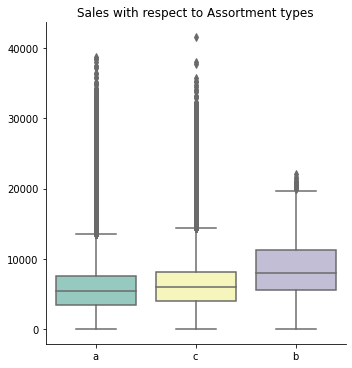

In [58]:
# Check how the assortment type affects sales
visualize.catplot(df_train_joined,y="Sales",x="Assortment",kind="box",title="Sales with respect to Assortment types")

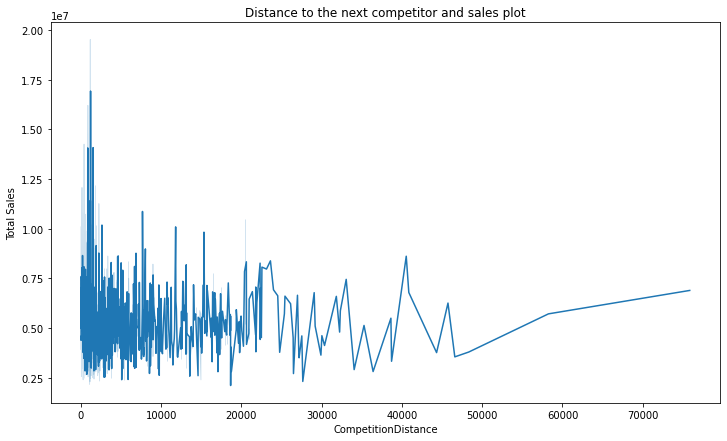

In [63]:
# How does the distance to the next competitor affect sales? 
# What if the store and its competitors all happen to be in city centres, does the distance matter in that case?
store_sales_df = pd.DataFrame({"Total Sales":df_train_joined.groupby("Store")["Sales"].sum()})
grouped_stores = store_sales_df.merge(df_store, on='Store')
visualize.lineplot(df = grouped_stores,x="CompetitionDistance",y="Total Sales",title="Distance to the next competitor and sales plot")


In [ ]:
# How does the opening or reopening of new competitors affect stores? Check for stores with NA as competitor distance but later on has values for competitor distance
